In [1]:
# config.py
epsilon_energy = 5.0
delta_energy = 5.0
lambda_energy = 0.25
alpha_fgsm = 8 / 255

num_classes = 10
batch_size = 16
epochs = 10
lr = 0.005
device = 'cuda'

## CIFAR-10 to PNG images (run once on your machine)

In [1]:
from download_CIFAR10 import extract_cifar10_as_images
extract_cifar10_as_images()

/home/artmgreen/DataspellProjects/manifold-projection-layer/.venv/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


## `torch` dataset and loader formation

In [2]:
# ? dataset.py ?
import torch

from torchvision.transforms import v2
from torchvision.transforms.functional import InterpolationMode

from torch.utils.data import DataLoader

from dataset import CIFAR10
# from config import batch_size


resnet18_preprocess = v2.Compose([
    v2.Resize(224, interpolation=InterpolationMode.BILINEAR),
    # v2.CenterCrop(224),
    v2.ToDtype(torch.float32, scale=True),  # to [0, 1]
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225])  # to ([0, 1]^3 - mean) / std
])

# what do we do with the changed range? It's not [0, 1] anymore, but we still clamp it to [0, 1] when doing an FGSM attack}

train_dataset = CIFAR10(root='./data', train=True, transform=resnet18_preprocess)
test_dataset = CIFAR10(root='./data', train=False, transform=resnet18_preprocess)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4, pin_memory=True)

## Model definition

In [3]:
# model.py
from model import ModelWrapper

In [4]:
# utils.py
import torch
import torch.nn.functional as F
#from config import alpha_fgsm

def fgsm_attack(model, x, y, loss_fn, alpha):
    model.eval()
    x_adv = x.detach().clone().requires_grad_(True)
    logits, _ = model(x_adv)
    loss = loss_fn(logits, y)
    loss.backward()
    x_adv = x_adv + alpha * x_adv.grad.sign()
    x_adv = torch.clamp(x_adv, 0, 1) # Clamping to [0, 1] when we shouldn't (?), see the section where we form a loader
    return x_adv.detach()

def compute_loss(model, x, y, loss_fn, epsilon, delta, lambda_energy):
    logits_clean, energy_clean = model(x)
    loss_clean = loss_fn(logits_clean, y, reduction="mean")
    # model.eval() is called inside fgsm_attack()
    x_adv = fgsm_attack(model, x, y, loss_fn, alpha_fgsm)
    model.train()
    logits_adv, energy_adv = model(x_adv)
    loss_adv = loss_fn(logits_adv, y, reduction="mean")

    loss_energy = 0
    if lambda_energy != 0:
        loss_energy = lambda_energy * (
            F.relu(energy_clean - epsilon) +
            F.relu(epsilon + delta - energy_adv)
        ).mean(dim=0)
        loss_energy = loss_energy.mean()

    total_loss = loss_clean + loss_adv + loss_energy

    metrics = {
        'L_clean': loss_clean.item(),
        'L_adv': loss_adv.item(),
        'L_energy': loss_energy.item(),
        'E_clean': energy_clean.mean().item(),
        'E_adv': energy_adv.mean().item(),
    }

    return total_loss, metrics

def predict_with_rejection(model, x, epsilon):
    logits, energy = model(x)
    preds = torch.argmax(logits, dim=1)
    rejected = energy.squeeze() > epsilon
    preds[rejected] = -1  # -1 means abstain
    return preds

## Model training

In [5]:
# train.py
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn.functional as F


#from utils import compute_loss
#from config import *

In [6]:
model = ModelWrapper(num_classes).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
loss_fn = F.cross_entropy

for epoch in range(epochs):
    model.train()
    total_metrics = {'L_clean': 0, 'L_adv': 0, 'L_energy': 0, 'E_clean': 0, 'E_adv': 0}
    progress_bar = tqdm(train_loader, total=len(train_loader))
    for x, y in progress_bar:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        loss, metrics = compute_loss(model, x, y, loss_fn, epsilon_energy, delta_energy, lambda_energy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        for k in total_metrics:
            total_metrics[k] += metrics[k]

        progress_bar.set_postfix(metrics)

    print(f"[Epoch {epoch+1}]")
    for k in total_metrics:
        print(f"  {k}: {total_metrics[k] / len(train_loader):.4f}")

  0%| | 9/3125 [00:02<16:10,  3.21it/s, L_clean=2.38, L_adv=2.48, L_energy=2.39,


KeyboardInterrupt: 

In [18]:
torch.save(model.state_dict(), "model.pt")

## Evaluation

In [7]:
model = ModelWrapper(num_classes).to(device)
model.load_state_dict(torch.load("resnet18_04aug.pt"))

<All keys matched successfully>

In [8]:
# evaluate.py
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
# from model import ModelWrapper
# from utils import fgsm_attack, predict_with_rejection
# from config import *

def evaluate(model, loader, abstention_threshold, examples=float("inf")):
    model.eval()

    all_clean_E = list()
    all_adv_E = list()

    clean_correct = 0
    clean_total = 0
    clean_rejects = 0
    clean_no_defense_correct = 0

    robust_correct = 0
    robust_total = 0
    robust_rejects = 0
    robust_no_defense_correct = 0

    # with torch.no_grad(): -- prohibited, we need gradients for FGSM attack
    i = -1
    for x, y in tqdm(loader, total=len(loader)):
        i += 1
        if i > examples:
            break
        x, y = x.to(device), y.to(device)

        logits_clean, energy_clean = model(x)
        all_clean_E.append(energy_clean.cpu().detach())
        preds_clean = torch.argmax(logits_clean, dim=1)
        reject_clean = (energy_clean.squeeze() > abstention_threshold)
        valid_clean = ~reject_clean

        clean_correct += (preds_clean[valid_clean] == y[valid_clean]).sum().item()
        clean_no_defense_correct += (preds_clean == y).sum().item()
        clean_rejects += reject_clean.sum().item()
        clean_total += y.size(0)

        x_adv = fgsm_attack(model, x, y, F.cross_entropy, alpha_fgsm)
        logits_adv, energy_adv = model(x_adv)
        all_adv_E.append(energy_adv.cpu().detach())
        preds_adv = torch.argmax(logits_adv, dim=1)
        reject_adv = (energy_adv.squeeze() > abstention_threshold)
        valid_adv = ~reject_adv

        robust_correct += (preds_adv[valid_adv] == y[valid_adv]).sum().item()
        robust_no_defense_correct += (preds_adv == y).sum().item()
        robust_rejects += reject_adv.sum().item()
        robust_total += y.size(0)


    if clean_total == clean_rejects:
        clean_acc = float("NaN")
    else:
        clean_acc = clean_correct / (clean_total - clean_rejects)
    clean_no_def_acc = clean_no_defense_correct / clean_total
    clean_reject_rate = clean_rejects / clean_total

    if robust_total == robust_rejects:
        robust_acc = float("NaN")
    else:
        robust_acc = robust_correct / (robust_total - robust_rejects)
    robust_no_def_acc = robust_no_defense_correct / robust_total
    robust_reject_rate = robust_rejects / robust_total

    print(f"Clean Accuracy (rejected samples excluded): {clean_acc:.4f}")
    print(f"Clean Accuracy (rejected samples included): {clean_no_def_acc:.4f}")
    print(f"Clean Rejection Rate:       {clean_reject_rate:.4f}")
    print(f"Robust Accuracy (rejected samples excluded): {robust_acc:.4f}")
    print(f"Robust Accuracy (rejected samples included): {robust_no_def_acc:.4f}")
    print(f"Adversarial Detection Rate:  {robust_reject_rate:.4f}")

    all_clean_E = torch.cat(all_clean_E).squeeze().numpy()
    all_adv_E = torch.cat(all_adv_E).squeeze().numpy()
    return all_clean_E, all_adv_E

import matplotlib.pyplot as plt
import numpy as np

def energy_hist(energy_clean, energy_adv, abstention_threshold, binwidth=0.5):
    plt.hist(energy_clean, alpha=0.5, label='Clean Energy', bins=np.arange(min(energy_clean), max(energy_clean) + binwidth, binwidth))
    plt.hist(energy_adv, alpha=0.5, label='Adversarial Energy', bins=np.arange(min(energy_clean), max(energy_clean) + binwidth, binwidth))
    plt.axvline(abstention_threshold, color='red', linestyle='--', label='Abstention Threshold')
    plt.xlabel("Energy")
    plt.ylabel("Count")
    plt.title("Energy Distribution: Clean vs Adversarial")
    plt.legend()
    plt.grid(True)
    plt.show()


100%|███████████████████████████████████████| 3125/3125 [07:04<00:00,  7.37it/s]


Clean Accuracy (rejected samples excluded): 1.0000
Clean Accuracy (rejected samples included): 0.9711
Clean Rejection Rate:       0.9925
Robust Accuracy (rejected samples excluded): 0.9783
Robust Accuracy (rejected samples included): 0.6585
Adversarial Detection Rate:  0.9991


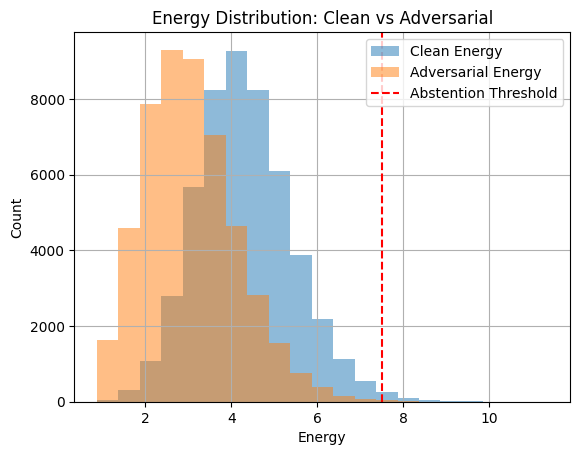

In [21]:
E_clean, E_adv = evaluate(model, train_loader, epsilon_energy+0.5*delta_energy)
energy_hist(E_clean, E_adv, epsilon_energy+0.5*delta_energy)

100%|█████████████████████████████████████████| 625/625 [01:24<00:00,  7.37it/s]


Clean Accuracy (rejected samples excluded): 0.9161
Clean Accuracy (rejected samples included): 0.8624
Clean Rejection Rate:       0.2611
Robust Accuracy (rejected samples excluded): 0.7260
Robust Accuracy (rejected samples included): 0.5400
Adversarial Detection Rate:  0.6584


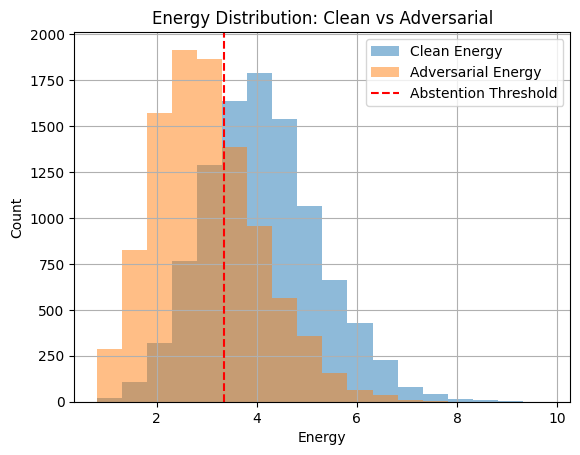

In [22]:
E_clean, E_adv = evaluate(model, test_loader, epsilon_energy-0.33*delta_energy)
energy_hist(E_clean, E_adv, epsilon_energy-0.33*delta_energy)